In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install segmentation_models_pytorch
from IPython.display import clear_output
clear_output()

In [6]:
import os
import zipfile
import cv2
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from tqdm import tqdm
import random  # Import the random module
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCDiscriminator(nn.Module):
    def __init__(self, num_classes, ndf=64):
        super(FCDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(ndf)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Reduce kernel size of classifier layer
        self.classifier = nn.Conv2d(ndf * 8, 1, kernel_size=3, stride=1, padding=1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.classifier(x)
        return x

# Ensure to update your training loop with this discriminator


In [8]:
# Preprocess the Dataset AUS
scaler = MinMaxScaler()
root_directory = '/content/drive/MyDrive/DLdataset'

image_dataset = []
mask_dataset = []

# Read images
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for image_name in images:
            if image_name.endswith(".png"):
                image = cv2.imread(os.path.join(path, image_name), 1)
                image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                image_dataset.append(image)

# Read masks
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        for mask_name in masks:
            if mask_name.endswith(".png"):
                mask = cv2.imread(os.path.join(path, mask_name), 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                mask_dataset.append(mask)

image_dataset = np.array(image_dataset, dtype=np.float32)
mask_dataset = np.array(mask_dataset, dtype=np.uint8)

# Define the RGB color for solar panels (assuming it's black in the mask)
SolarPanel = [0, 0, 0]  # Adjust this color if necessary

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    label_seg[np.all(label == SolarPanel, axis=-1)] = 1  # 1 for solar panel, 0 for background
    return label_seg

labels = [rgb_to_2D_label(mask) for mask in mask_dataset]
labels = np.array(labels)
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


In [9]:
# Preprocess the Dataset USA
scaler = MinMaxScaler()
root_directory_US = '/content/drive/MyDrive/solar_panels_with_new_USA'
desired_shape = (256, 256)  # Specify the desired shape

image_datasetUS = []
mask_datasetUS = []
max_images = 864  # Number of images to load

# Read images and corresponding masks
image_count = 0
for path, subdirs, files in os.walk(root_directory_US):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images1 = sorted(os.listdir(path))  # Sort to maintain order
        for image_name1 in images1:
            if image_name1.endswith(".png"):
                image_path = os.path.join(path, image_name1)
                mask_name = image_name1.replace('image', 'mask')  # Adjusting naming convention
                mask_path = os.path.join(root_directory_US, 'masks', mask_name)  # Assuming masks are in a subfolder named 'masks'

                # Check if corresponding mask exists
                if os.path.exists(mask_path):
                    image1 = cv2.imread(image_path, 1)
                    mask1 = cv2.imread(mask_path, 1)

                    if image1 is not None and mask1 is not None:
                        image1 = cv2.resize(image1, desired_shape)  # Resize image
                        image1 = scaler.fit_transform(image1.reshape(-1, image1.shape[-1])).reshape(image1.shape)
                        mask1 = cv2.resize(mask1, desired_shape)  # Resize mask
                        mask1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)

                        image_datasetUS.append(image1)
                        mask_datasetUS.append(mask1)
                        image_count += 1

                        if image_count >= max_images:
                            break
                else:
                    print(f"Mask not found for image: {image_path}")
        if image_count >= max_images:
            break

image_datasetUS = np.array(image_datasetUS, dtype=np.float32)
mask_datasetUS = np.array(mask_datasetUS, dtype=np.uint8)

# Define the RGB color for solar panels (assuming it's black in the mask)
SolarPanel = [0, 0, 0]  # Adjust this color if necessary

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape[:2], dtype=np.uint8)
    label_seg[np.all(label == SolarPanel, axis=-1)] = 1  # 1 for solar panel, 0 for background
    return label_seg

labelsUS = [rgb_to_2D_label(mask) for mask in mask_datasetUS]
labelsUS = np.array(labelsUS)
print("Unique labels in label dataset are: ", np.unique(labelsUS))
print(f"Number of images loaded: {len(image_datasetUS)}")
print(f"Number of masks loaded: {len(mask_datasetUS)}")



Unique labels in label dataset are:  [0 1]
Number of images loaded: 864
Number of masks loaded: 864


In [10]:
# Split the data into training and test sets austrlia data AUS
image_train, image_test, label_train, label_test = train_test_split(image_dataset, labels, test_size=0.2, random_state=42)

# Split the data into training and test sets austrlia data USA
image_train_US, image_test_US, label_train_US, label_test_US = train_test_split(image_datasetUS, labelsUS, test_size=0.2, random_state=42)

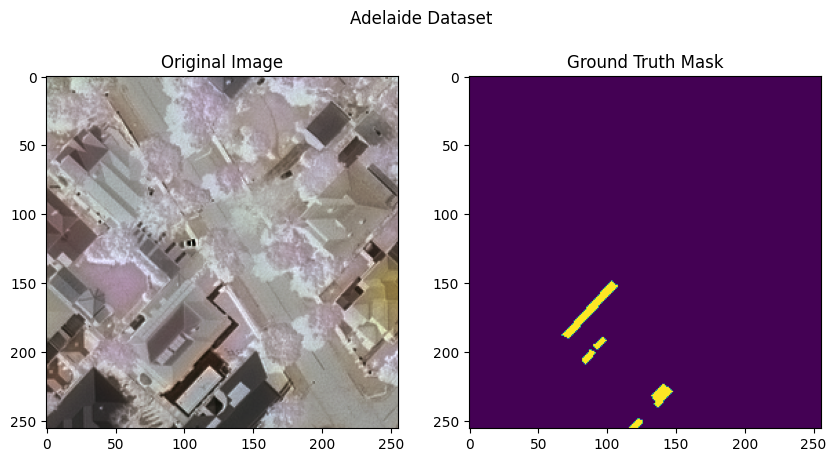

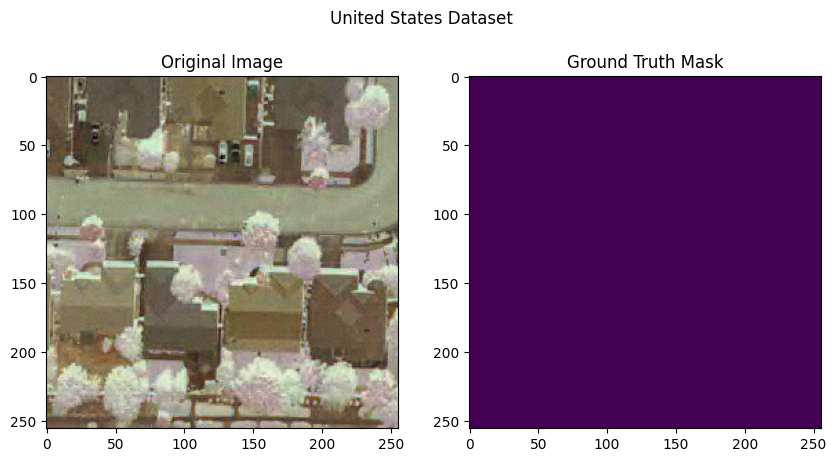

In [11]:
# Sanity check: display one image and its corresponding mask
def display_sample(image, mask, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.suptitle(title)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.suptitle(title)
    plt.title('Ground Truth Mask')
    plt.show()

# Display one sample before training AUS
random_idx1 = random.randint(0, len(image_dataset) - 1)
display_sample(image_dataset[random_idx1], labels[random_idx1],"Adelaide Dataset")

# Display one sample before training USA
random_idx2 = random.randint(0, len(image_datasetUS) - 1)
display_sample(image_datasetUS[random_idx2], labelsUS[random_idx2],"United States Dataset")

In [12]:
# Integrate Preprocessed Data into Training and Validation Script
class AerialDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

transform = transforms.Compose([
    transforms.ToTensor()
])

# Create training and validation datasets AUS
train_dataset = AerialDataset(image_train, label_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = AerialDataset(image_test, label_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Create training and validation datasets USA
train_dataset_US = AerialDataset(image_train_US, label_train_US, transform=transform)
train_dataloader_US = DataLoader(train_dataset_US, batch_size=4, shuffle=True)

test_dataset_US = AerialDataset(image_test_US, label_test_US, transform=transform)
test_dataloader_US = DataLoader(test_dataset_US, batch_size=4, shuffle=False)

In [23]:
NUM_CLASSES = 2  # 2 classes: background and solar panel
GPU = 0
SEED = 2023

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and discriminator
model = smp.FPN("resnet18", classes=NUM_CLASSES, in_channels=3, encoder_weights=None)
model.to(device)

model_D = FCDiscriminator(num_classes=NUM_CLASSES)
model_D.to(device)

# Define loss function and optimizers
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Adversarial training variables
lambda_adv_target = 0.001
source_label = 0
target_label = 1

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    model_D.train()
    running_loss = 0.0
    for images, masks in train_dataloader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    scheduler.step(epoch_loss)

    # Train with target data for adversarial loss
    for images, _ in train_dataloader_US:
        images = images.to(device, dtype=torch.float)
        optimizer_D.zero_grad()

        with torch.no_grad():
            preds = model(images)
        D_out = model_D(F.softmax(preds, dim=1))
        loss_adv_target = F.binary_cross_entropy_with_logits(D_out, torch.full_like(D_out, source_label, device=device))
        loss_adv_target.backward()
        optimizer_D.step()

    # Train discriminator with source data
    for images, masks in train_dataloader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device)
        optimizer_D.zero_grad()

        with torch.no_grad():
            preds = model(images)
        D_out = model_D(F.softmax(preds, dim=1))
        loss_D = F.binary_cross_entropy_with_logits(D_out, torch.full_like(D_out, source_label, device=device))
        loss_D.backward()
        optimizer_D.step()

    # Train discriminator with target data
    for images, _ in train_dataloader_US:
        images = images.to(device, dtype=torch.float)
        optimizer_D.zero_grad()

        with torch.no_grad():
            preds = model(images)
        D_out = model_D(F.softmax(preds, dim=1))
        loss_D = F.binary_cross_entropy_with_logits(D_out, torch.full_like(D_out, target_label, device=device))
        loss_D.backward()
        optimizer_D.step()

Epoch 1/30, Loss: 0.0140
Epoch 2/30, Loss: 0.0072
Epoch 3/30, Loss: 0.0062
Epoch 4/30, Loss: 0.0058
Epoch 5/30, Loss: 0.0052
Epoch 6/30, Loss: 0.0050
Epoch 7/30, Loss: 0.0047
Epoch 8/30, Loss: 0.0049
Epoch 9/30, Loss: 0.0043
Epoch 10/30, Loss: 0.0041
Epoch 11/30, Loss: 0.0040
Epoch 12/30, Loss: 0.0040
Epoch 13/30, Loss: 0.0040
Epoch 14/30, Loss: 0.0036
Epoch 15/30, Loss: 0.0032
Epoch 16/30, Loss: 0.0030
Epoch 17/30, Loss: 0.0029
Epoch 18/30, Loss: 0.0029
Epoch 19/30, Loss: 0.0031
Epoch 20/30, Loss: 0.0023
Epoch 21/30, Loss: 0.0022
Epoch 22/30, Loss: 0.0022
Epoch 23/30, Loss: 0.0020
Epoch 24/30, Loss: 0.0022
Epoch 25/30, Loss: 0.0021
Epoch 26/30, Loss: 0.0017
Epoch 27/30, Loss: 0.0017
Epoch 28/30, Loss: 0.0016
Epoch 29/30, Loss: 0.0016
Epoch 30/30, Loss: 0.0016


In [24]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks, preds, idx):
    image = images[idx].cpu().numpy().transpose(1, 2, 0)
    mask = masks[idx].cpu().numpy()
    pred = preds[idx].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    axs[1].axis('off')

    axs[2].imshow(pred)
    axs[2].set_title('Predicted Mask', color='red' if np.any(pred == 1) else 'black')
    axs[2].axis('off')

    plt.show()

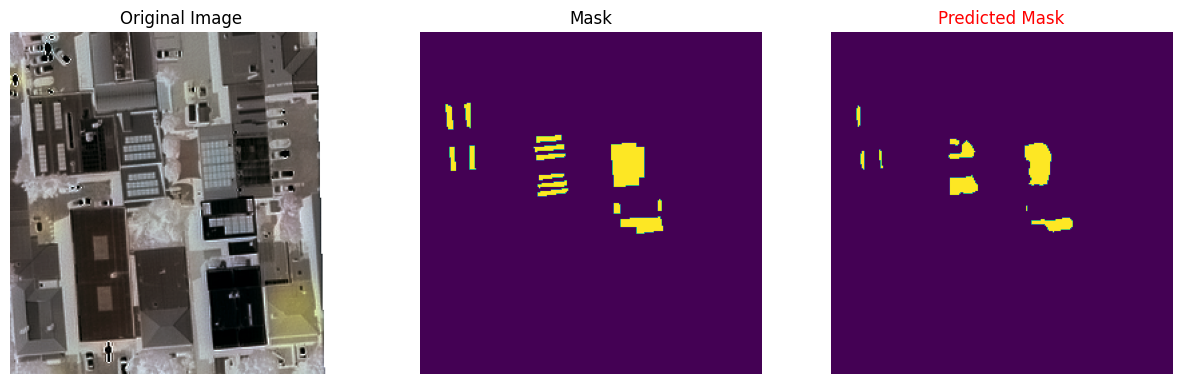

In [25]:
# Visualize some predictions
model.eval()
with torch.no_grad():
    for images, masks in train_dataloader:
        images, masks = images.to(device, dtype=torch.float), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        # Visualize the first batch
        visualize_predictions(images, masks, preds, 0)
        break

In [26]:
# Define a function to calculate mIoU
def calculate_miou(y_true, y_pred, num_classes):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    iou = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    return np.nanmean(iou)

# Validation function
def validate(model, dataloader, device, num_classes):
    model.eval()
    all_preds = []
    all_masks = []
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validating"):
            images, masks = images.to(device, dtype=torch.float), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Calculate mIoU
    miou = calculate_miou(all_masks, all_preds, num_classes)

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_masks.flatten(), all_preds.flatten())
    recall = recall_score(all_masks.flatten(), all_preds.flatten())
    f1 = f1_score(all_masks.flatten(), all_preds.flatten())

    return miou, precision, recall, f1

# Assuming the model is already defined and trained, and the test_dataloader is set up
num_classes = 2  # Set this to the number of classes in your dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Validate the model on the first test set
miou1, precision1, recall1, f1_1 = validate(model, test_dataloader_US, device, num_classes)
print(f"Dataset 1 - mIoU: {miou1:.4f}, Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1-Score: {f1_1:.4f}")




Validating: 100%|██████████| 44/44 [00:00<00:00, 109.63it/s]


Dataset 1 - mIoU: 0.5333, Precision: 0.4771, Recall: 0.0758, F1-Score: 0.1309


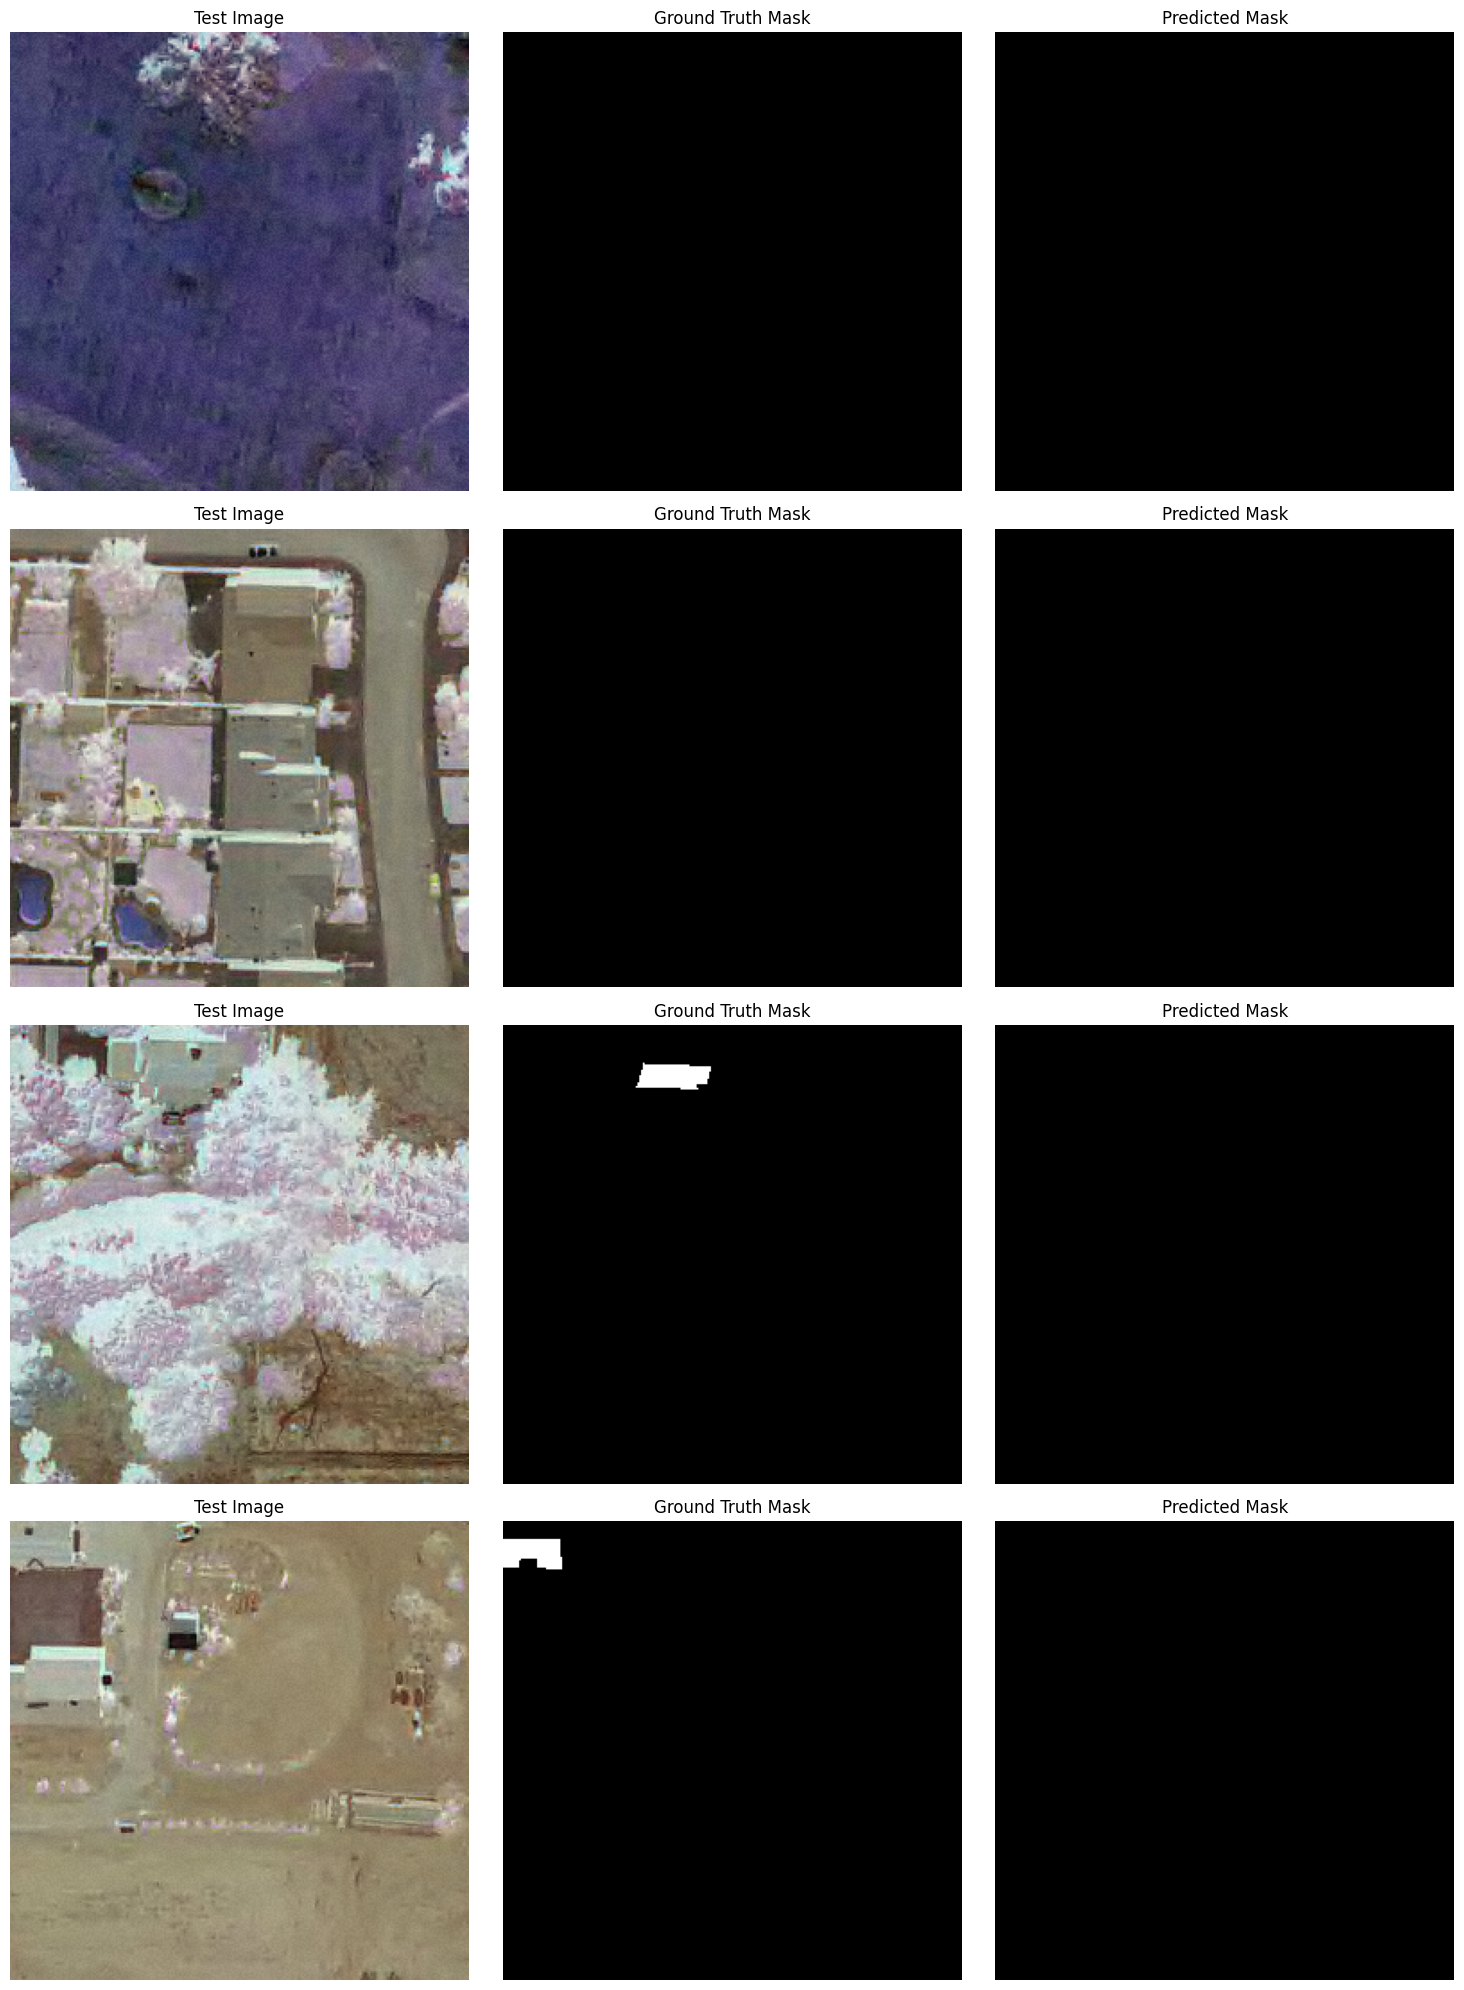

In [27]:
def plot_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device, dtype=torch.float), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Limit the number of images to the batch size
    num_images = min(num_images, len(images))

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].transpose(1, 2, 0))
        axes[i, 0].set_title('Test Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(preds[i], cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot predictions for a few test images
plot_predictions(model, test_dataloader_US, device, num_images=5)


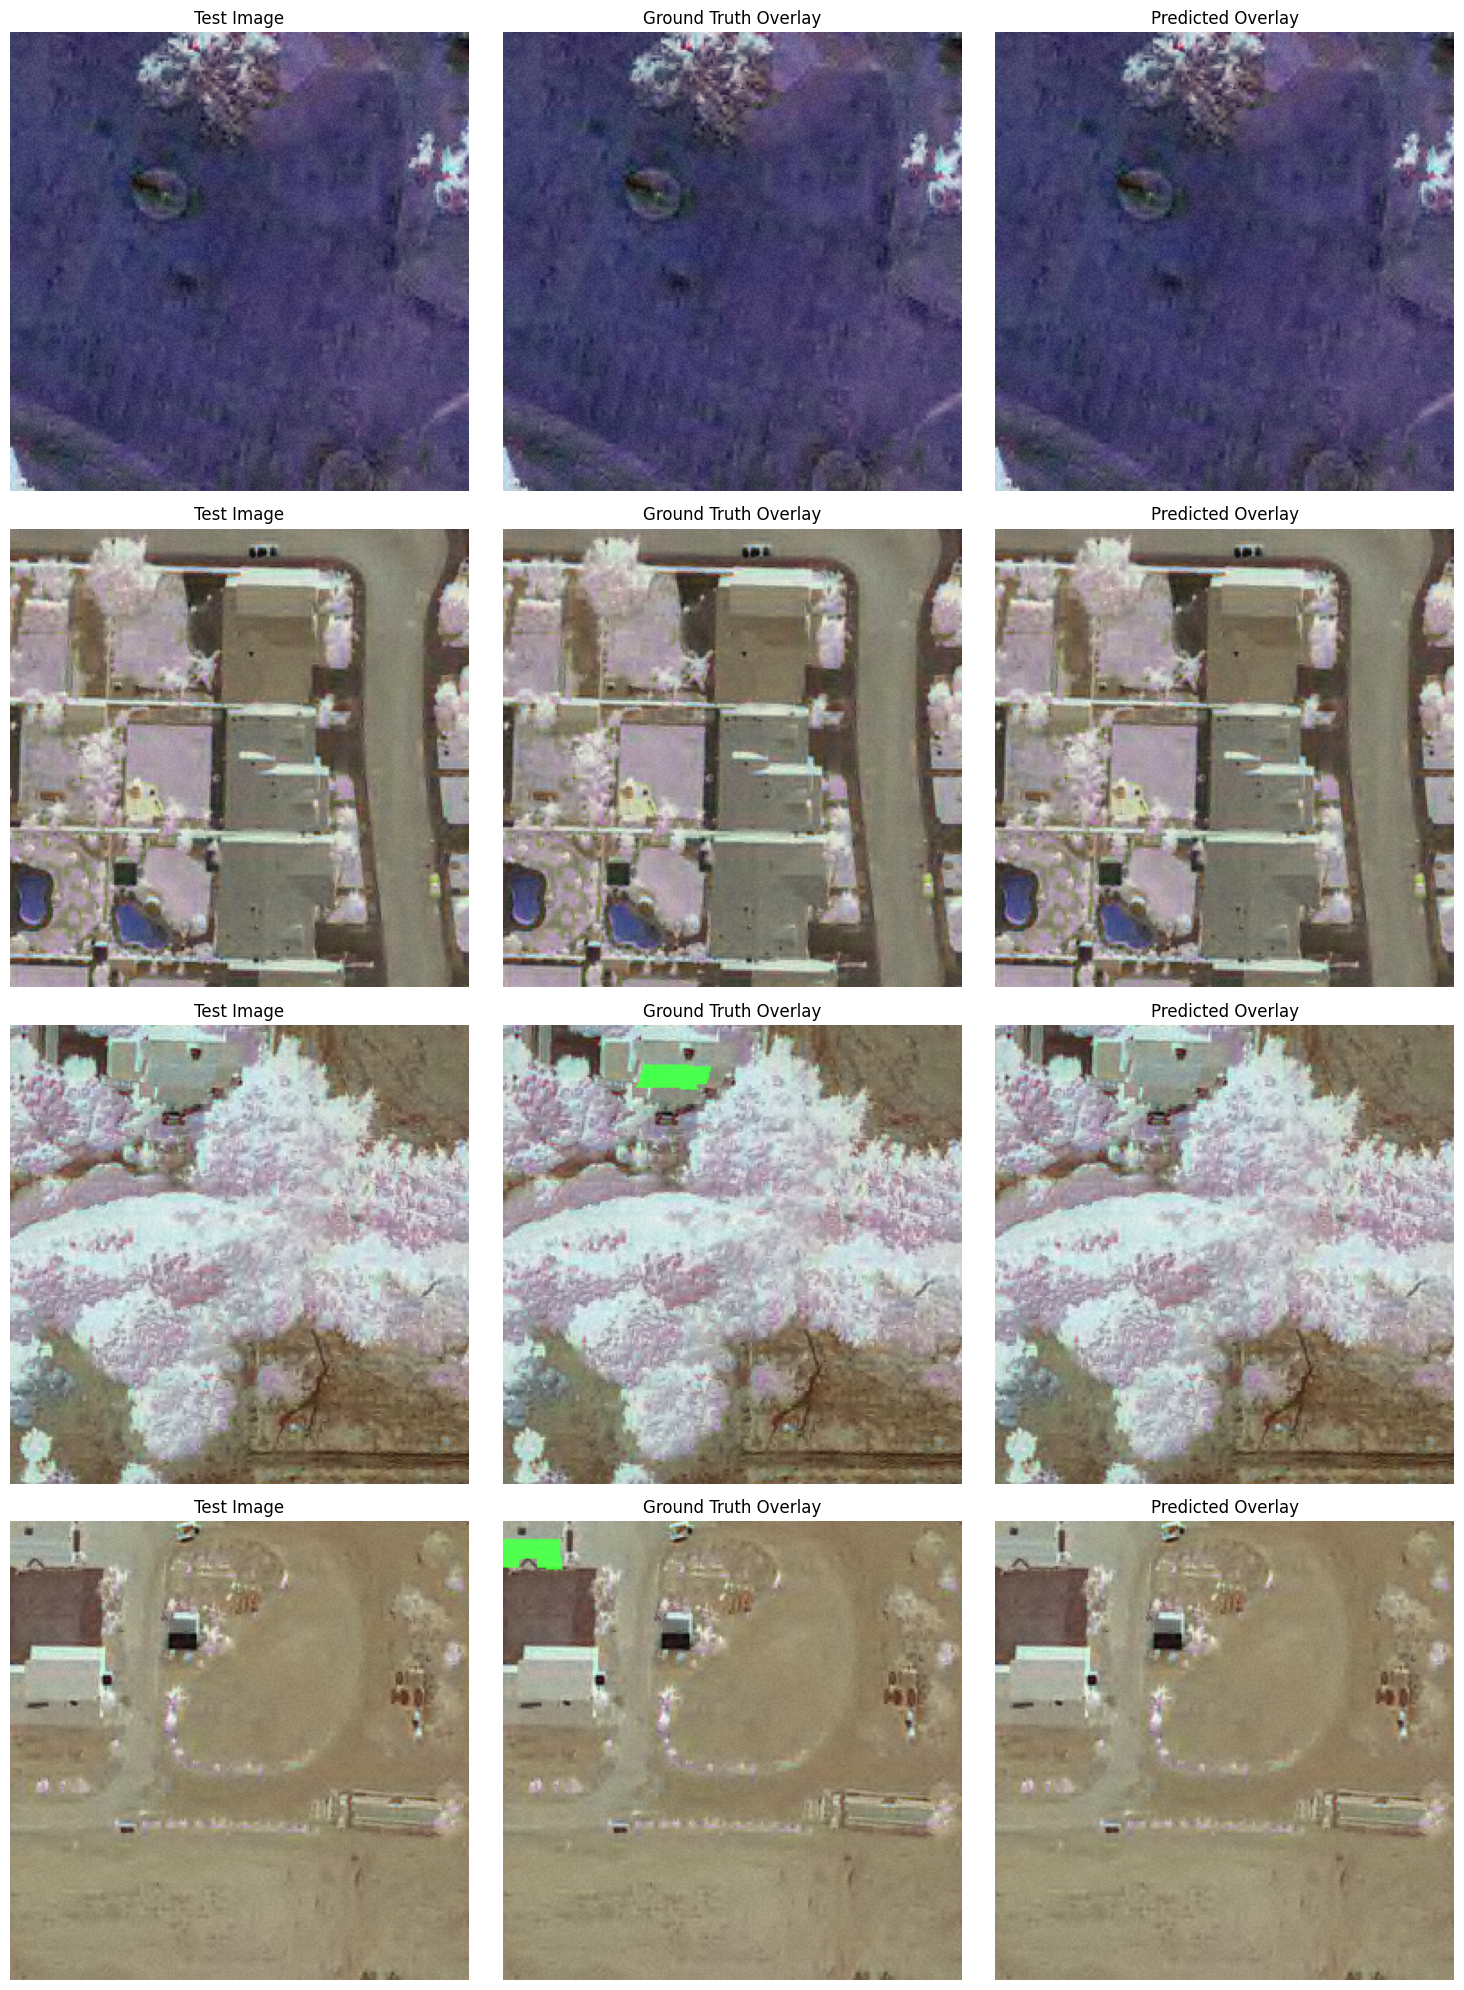

In [32]:
import matplotlib.pyplot as plt

def overlay_mask(image, mask, color=[0, 255, 0], alpha=0.5):
    """Overlay the mask on the image with the specified color and transparency."""
    color = np.array(color)
    overlay = image.copy()
    overlay[mask == 1] = color
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

def plot_overlay_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device, dtype=torch.float), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # (batch, height, width, channels)
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Limit the number of images to the batch size
    num_images = min(num_images, len(images))

    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        # Overlay ground truth mask
        gt_overlay = overlay_mask(images[i], masks[i])
        # Overlay predicted mask
        pred_overlay = overlay_mask(images[i], preds[i])

        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Test Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title('Ground Truth Overlay')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_overlay)
        axes[i, 2].set_title('Predicted Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot overlay predictions for a few test images
plot_overlay_predictions(model, test_dataloader_US, device, num_images=5)
